In [55]:
DATASET = "swedish_tunes_int.csv"
DATASET_SIZE = 20000
TRANSLATION_FILE = "translation"
INPUT_SIZE = 5
HIDDEN_NODES = 640
NUM_LAYERS = 1
SEED = 0
LEARNING_RATE = 0.1

In [2]:
translation_p = open(TRANSLATION_FILE, 'r')
translation_lines = translation_p.readlines()
num_tokens = len(translation_lines)

translation_p.close()
num_tokens

1178

In [61]:
import pandas
from torch.nn import RNN, Linear, Softmax, Module
import torch
import math
import tqdm
import plotnine

In [4]:
# Class that creates the model that we'll use
class PredictRNN(Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PredictRNN, self).__init__()

        self.rnn = RNN(input_size, hidden_size, num_layers=num_layers)
        self.h2o = Linear(hidden_size, output_size)
        self.softmax = Softmax(dim=0)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output

In [5]:
# Get min number of tokens in a line
def trim_small_lines(filepath, input_size):
    file_p = open(filepath, 'r')
    lines = list(file_p.readlines())
    for line in lines:
        line_tok = line.split(',')
        line_len = len(line_tok)
        if line_len < input_size:
            lines.remove(line)
    file_p.close()
    return lines

trim_small_lines(DATASET, INPUT_SIZE)[:5]

['0,1,2,3,4,5,3,6,3,5,3,7,5,5,5,8,5,3,5,4,7,3,4,5,3,6,3,5,3,7,5,5,5,8,9,10,11,12,13,14,13,7,5,5,5,15,15,3,16,3,7,12,13,14,13,7,5,5,5,8,9,17\n',
 '0,1,2,18,19,20,21,22,6,7,23,3,15,23,12,7,6,6,22,24,25,3,12,26,7,27,22,22,21,18,7,13,23,15,27,28,7,29,19,22,23,12,30,31,32,12,12,7,6,20,29,19,33,29,19,20,7,18,19,20,21,22,6,7,23,3,15,23,12,17\n',
 '0,1,2,22,6,23,15,13,18,7,33,29,19,22,34,7,6,6,22,3,15,3,16,13,35,7,24,12,6,23,6,20,7,22,6,23,15,13,18,7,33,29,19,22,34,30,19,36,37,15,6,19,33,7,38,39,39,29,33,7,40,33,29,19,26,38,7,12,20,29,41,17\n',
 '0,1,2,24,4,25,13,3,25,7,3,5,8,23,9,7,6,6,29,4,8,25,5,3,3,3,3,7,8,25,5,15,3,6,6,6,7,8,25,5,3,25,3,3,3,7,3,5,8,23,9,30,12,12,31,32,7,12,42,43,7,24,4,25,13,3,25,7,3,5,8,23,9,17\n',
 '0,1,2,44,45,23,15,7,46,47,48,47,12,7,6,20,49,50,51,46,52,46,50,46,7,6,25,15,3,7,46,47,48,5,8,7,47,52,50,53,24,30,54,45,3,20,7,3,20,19,20,7,44,45,23,15,7,46,47,48,47,12,17\n']

In [58]:
# calculates the accuracy of the predictions of a neural network
# For classification tasks
# NOTE: X and y should already be PyTorch tensors
def calculate_accuracy(network, X, y):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        X = X.to(device)
        y = y.to(device)
    # make predictions for the given X
    predictions = []
    # for X_vec in X:
    #     prob = network(X_vec)
    #     pred = torch.argmax(prob, dim=0)
    #     print(pred)
    #     predictions.append(pred)
    # print(predictions)
    probs = network(X)
    predictions = torch.argmax(probs, dim=1)
    # the calculate accuracy of those predictions
    # correct = 0
    total = len(predictions)
    # for prediction, y_label in zip(predictions, y):
    #     if prediction == y:
    #         correct += 1

    accuracy = float(sum(predictions == y) / total)
    variance = accuracy * (1 - accuracy)
    std_err = math.sqrt(variance / total)
    up_bound = accuracy + 2.39 * std_err
    low_bound = accuracy - 2.39 * std_err
    return accuracy, up_bound, low_bound


In [7]:
# converts a training set into smaller train and validation sets
def create_validation(training_X, training_y, valid_percentage):
    # find the split point between training and validation
    training_n = training_X.shape[0]
    valid_rows = int(valid_percentage * training_n)

    # create the validation set
    valid_X = training_X.iloc[:valid_rows]
    valid_y = training_y.iloc[:valid_rows]

    # create the (smaller) training set
    train_X = training_X.iloc[valid_rows:]
    train_y = training_y.iloc[valid_rows:]

    return train_X, train_y, valid_X, valid_y


In [50]:
# trains a neural network with given training data
def train_network(network, training_X, training_y, lr, nn_filepath):
    # split the training data into train and validation
    # Note: use 20% of the original training data for validation
    # train_X, train_y, valid_X, valid_y = create_validation(training_X, training_y, 0.2)
    # train_X_len = len(train_X)
    # elements = len(train_X.columns)
    # valid_X_len = len(valid_X)

    # convert our data to PyTorch objects
    train_X = torch.from_numpy(training_X.values).float().unsqueeze(0)
    # train_X = train_X.reshape((train_X_len, 1, elements))
    # train_X = train_X.transpose(0, 1)
    train_y = torch.from_numpy(training_y.values).long()
    # valid_X = torch.from_numpy(valid_X.values).float()
    # valid_X = valid_X.transpose(0, 1)
    # valid_X = valid_X.reshape((valid_X_len, 1, elements))
    # valid_y = torch.from_numpy(valid_y.values).long()

    # move the data and model to the GPU if possible
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print(f"Using device {torch.cuda.get_device_name(device)}")
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        # valid_X = valid_X.to(device)
        # valid_y = valid_y.to(device)
        network = network.to(device)

    # create the algorithm that learns the weight for the network
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)

    # create the loss function that tells optimizer how much error it has in its predictions
    # here we use cross entropy since we have a classification task with more than two possible labels
    loss_function = torch.nn.CrossEntropyLoss()

    # train for 1000 epochs
    num_epochs = 200
    train_loss_values = []
    # valid_loss_values = []
    train_acc_values = []
    # valid_acc_values = []
    for epoch in tqdm.trange(num_epochs):
        # make predictions on the training set and validation set
        epoch_loss = 0
        for X_vec, y_label in zip(train_X, train_y):
            prediction = network(X_vec)
            loss = loss_function(prediction, y_label)
            epoch_loss += loss
        # train_predictions = network(train_X)
        # valid_predictions = network(valid_X)
        # train_loss = loss_function(train_predictions, train_y)

        # perform backpropagation
        optimizer.zero_grad()
        epoch_loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss.item() / len(train_X)
        # calculate the error on the training set
        train_loss_values.append(epoch_loss)
        # valid_loss_values.append(loss_function(valid_predictions, valid_y).item())
        train_acc_values.append(calculate_accuracy(network, train_X, train_y))
        # valid_acc = calculate_accuracy(network, valid_X, valid_y)
        # valid_acc_values.append(valid_acc)

        # # Early return for perfect fit
        # if valid_acc == 1:
        #     # convert the training progress data to a Pandas DataFrame
        #     progress = {
        #         "epoch": range(epoch+1),
        #         "train_loss": train_loss_values,
        #         # "valid_loss": valid_loss_values,
        #         "train_acc": train_acc_values,
        #         # "valid_acc": valid_acc_values
        #     }
        #     torch.save(network, nn_filepath)
        #     return pandas.DataFrame(progress)


    # convert the training progress data to a Pandas DataFrame
    progress = {
        "epoch": range(num_epochs),
        "train_loss": train_loss_values,
        # "valid_loss": valid_loss_values,
        "train_acc": train_acc_values,
        # "valid_acc": valid_acc_values
    }
    torch.save(network, nn_filepath)
    progress = pandas.DataFrame(progress)
    progress.to_csv('rnn_progress.csv')
    return pandas.DataFrame(progress)


In [9]:
def process_dataset(dataset_filepath, input_size, seed=SEED, num_rows=DATASET_SIZE):
    lines = trim_small_lines(dataset_filepath, input_size)
    # We need to create a dataframe with the proper number of columns
    # Get the first three tokens from every line and store them in front of each instance
    dataframe_dict = {
        'timesig': [],
        'key': [],
        'style': []
    }

    for i in range(input_size):
        dataframe_dict[i] = []

    for line in lines:
        line = line.split(',')
        timesig = int(line[0])
        key = int(line[1])
        style = int(line[2])
        remainder = list(map(int, line[3:]))
        for i in range(len(remainder) - input_size):
            window = remainder[i:i+input_size]
            dataframe_dict['timesig'].append(timesig)
            dataframe_dict['key'].append(key)
            dataframe_dict['style'].append(style)
            for ind, token in enumerate(window):
                dataframe_dict[ind].append(token)

    return pandas.DataFrame(dataframe_dict).sample(frac=1, random_state=seed).head(num_rows)

process_dataset(DATASET, INPUT_SIZE)

,timesig,key,style,0,1,2,3,4
119510,0,1,575,42,13,7,14,13
31816,64,1,274,121,79,11,20,6
898913,0,179,800,6,7,193,7,65
295356,128,179,172,25,7,163,55,25
531065,128,1,172,55,212,55,7,4
...,...,...,...,...,...,...,...,...
550391,128,179,172,5,25,56,6,23
675837,128,179,725,35,182,35,187,35
443776,128,1,172,50,66,50,7,99
147338,0,1,442,23,60,20,13,61


In [38]:
# Splits a dataset into training and test sets,
def split_dataset(dataset, train_data_ratio, y_label, seed=SEED):
    train_int = int(train_data_ratio * len(dataset))
    training = dataset.iloc[:train_int]
    test = dataset.iloc[train_int:]
    training_y = training[y_label]
    training_X = training.drop(columns=y_label)
    test_y = test[y_label]
    test_X = test.drop(columns=y_label)
    return training_X, training_y, test_X, test_y

dataset = process_dataset(DATASET, INPUT_SIZE)
training_X, training_y, test_X, test_y = split_dataset(dataset, 0.9, 4, 0)
training_X


,timesig,key,style,0,1,2,3
119510,0,1,575,42,13,7,14
31816,64,1,274,121,79,11,20
898913,0,179,800,6,7,193,7
295356,128,179,172,25,7,163,55
531065,128,1,172,55,212,55,7
...,...,...,...,...,...,...,...
238271,128,179,172,7,187,298,185
470286,128,1,172,3,23,3,7
422177,128,1,172,150,5,3,15
674376,128,1,725,26,26,28,7


In [11]:
# Performs one-hot encoding on dataset AFTER process_dataset
# Napkin estimates this would take 27 hours to run on swedish dataset
def onehots(dataframe, n_tokens):
    ret_frame = pandas.DataFrame()
    for column_name, column in dataframe.items():
        oh_dict = {}
        for ix in range(n_tokens):
            oh_dict[str(column_name) + '_' + str(ix)] = []
        for item in column:
            print(item)
            for key, array in oh_dict.items():
                if item == int(key.split('_')[1]):
                    array.append(1)
                else:
                    array.append(0)
        ret_frame = pandas.concat([ret_frame, pandas.DataFrame(oh_dict)], axis=1)
    return ret_frame

In [59]:
dataset = process_dataset(DATASET, INPUT_SIZE, num_rows=DATASET_SIZE)
training_X, training_y, test_X, test_y = split_dataset(dataset, 0.9, 4, 0)
rnn = PredictRNN(INPUT_SIZE+2, HIDDEN_NODES, NUM_LAYERS, num_tokens)
results = train_network(rnn, training_X, training_y, LEARNING_RATE, 'trained_rnn.pt')
test_X = torch.from_numpy(test_X.values).float().unsqueeze(0)
test_y = torch.from_numpy(test_y.values).long()
accuracy, up_bound, low_bound = calculate_accuracy(rnn, test_X, test_y)
print(f"Accuracy: {accuracy:.3f}")
print(f"95% Confidence Interval: [{low_bound:.3f}, {up_bound:.3f}]")


Using device AMD Radeon RX 7900 XT


100%|██████████| 200/200 [04:11<00:00,  1.26s/it]

Accuracy: 0.016
95% Confidence Interval: [0.009, 0.023]


In [39]:
dataset = process_dataset(DATASET, INPUT_SIZE)
training_X, training_y, test_X, test_y = split_dataset(dataset, 0.9, 4, 0)
rnn = torch.load('trained_rnn.pt')
test_X = torch.from_numpy(test_X.values).float().unsqueeze(0)
test_y = torch.from_numpy(test_y.values).long()
accuracy, up_bound, low_bound = calculate_accuracy(rnn, test_X, test_y)
print(f"Accuracy: {accuracy:.3f}")
print(f"95% Confidence Interval: [{low_bound:.3f}, {up_bound:.3f}]")


Accuracy: 0.016
95% Confidence Interval: [0.009, 0.023]


/tmp/ipykernel_10916/3255440893.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn = torch.load('trained_rnn.pt')


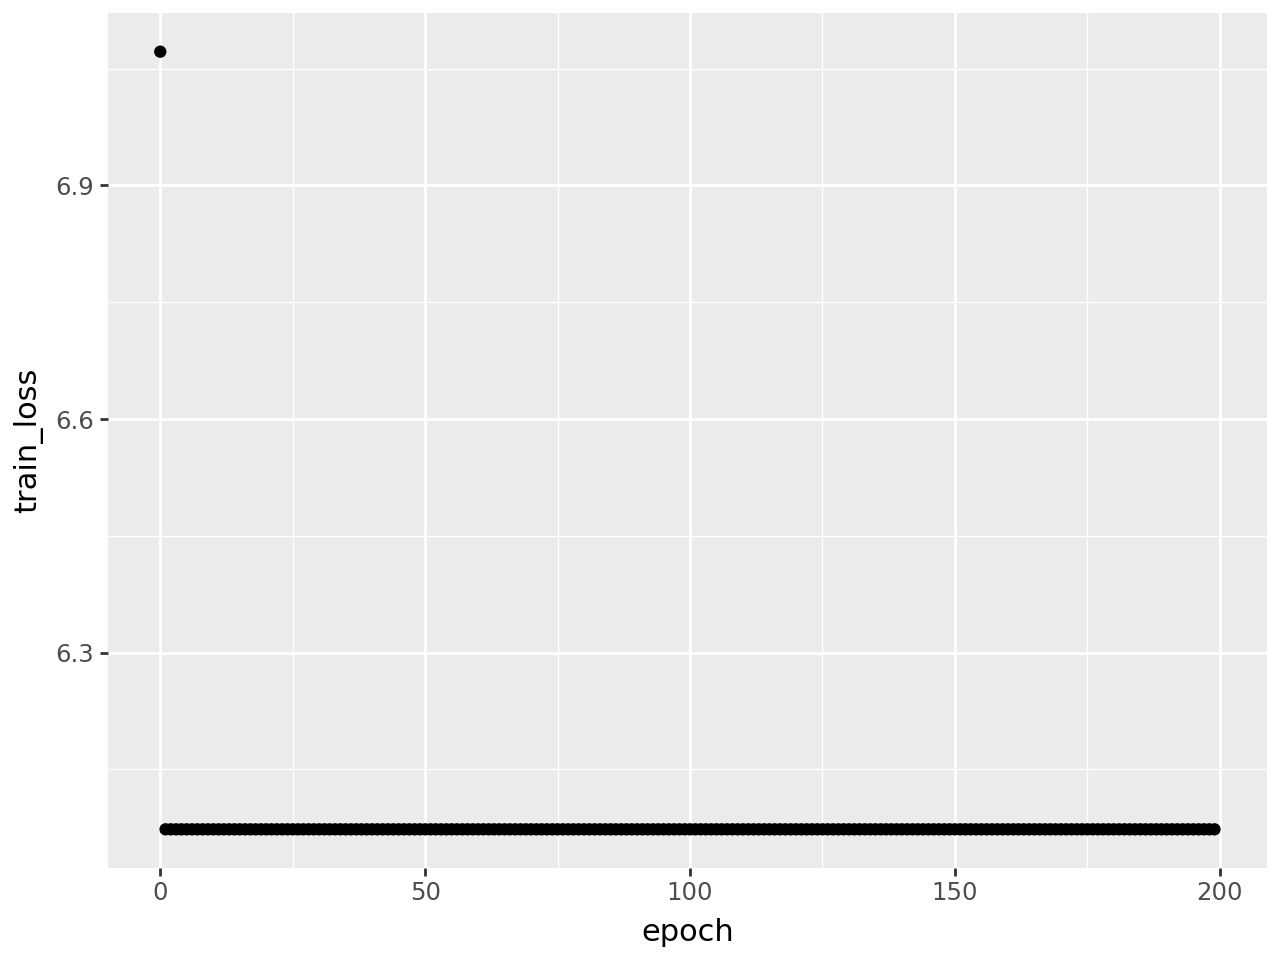

In [66]:
results_frame = pandas.read_csv('rnn_progress.csv')

plot = plotnine.ggplot(results_frame, plotnine.aes('epoch', 'train_loss')) + plotnine.geom_point()
plot.show()